In [1]:
from google.cloud import bigquery
import pandas as pd
from scipy.cluster.vq import kmeans

In [2]:
pd.set_option('max_info_columns', 200)


In [3]:
client = bigquery.Client()

In [4]:
orders_query = """
SELECT
    order_id,
    user_id,
    status,
    gender,
    created_at AS order_date,
    num_of_item
FROM `bigquery-public-data.thelook_ecommerce.orders`
ORDER BY order_id
"""

In [5]:
order_item_query = """
SELECT
    order_id,
    user_id,
    product_id,
    inventory_item_id,
    sale_price
FROM `bigquery-public-data.thelook_ecommerce.order_items`
ORDER BY order_id
"""

In [6]:
inventory_items_query = """
SELECT DISTINCT
    product_id,
    cost,
    product_category,
    product_name,
    product_retail_price,
    product_department
FROM `bigquery-public-data.thelook_ecommerce.inventory_items`
"""

In [7]:
df_order = client.query(orders_query).to_dataframe()

/home/kamcio/Coding/Python/Churn/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [8]:
df_order_item = client.query(order_item_query).to_dataframe()

/home/kamcio/Coding/Python/Churn/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [9]:
df_inventory_items = client.query(inventory_items_query).to_dataframe()

/home/kamcio/Coding/Python/Churn/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [10]:
inventory_df = df_inventory_items.copy()
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29054 entries, 0 to 29053
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            29054 non-null  Int64  
 1   cost                  29054 non-null  float64
 2   product_category      29054 non-null  object 
 3   product_name          29054 non-null  object 
 4   product_retail_price  29054 non-null  float64
 5   product_department    29054 non-null  object 
dtypes: Int64(1), float64(2), object(3)
memory usage: 1.4+ MB


In [11]:
orders_df = df_order.copy()
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125084 entries, 0 to 125083
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   order_id     125084 non-null  Int64              
 1   user_id      125084 non-null  Int64              
 2   status       125084 non-null  object             
 3   gender       125084 non-null  object             
 4   order_date   125084 non-null  datetime64[us, UTC]
 5   num_of_item  125084 non-null  Int64              
dtypes: Int64(3), datetime64[us, UTC](1), object(2)
memory usage: 6.1+ MB


In [12]:
order_item_df = df_order_item.copy()
order_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181446 entries, 0 to 181445
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           181446 non-null  Int64  
 1   user_id            181446 non-null  Int64  
 2   product_id         181446 non-null  Int64  
 3   inventory_item_id  181446 non-null  Int64  
 4   sale_price         181446 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 7.6 MB


In [13]:
orders_df.head()

,order_id,user_id,status,gender,order_date,num_of_item
0,1,1,Shipped,F,2022-04-30 09:37:00+00:00,2
1,2,2,Complete,F,2024-07-16 14:52:00+00:00,2
2,3,4,Processing,F,2023-11-26 12:03:00+00:00,1
3,4,5,Processing,F,2024-12-30 06:04:00+00:00,1
4,5,5,Processing,F,2025-01-28 06:04:00+00:00,4


In [14]:
order_item_df.head()

,order_id,user_id,product_id,inventory_item_id,sale_price
0,1,1,15649,3,14.970000
1,1,1,98,5,39.990002
2,2,2,13449,7,25.000000
3,2,2,8212,10,98.080002
4,3,4,1230,12,110.000000


In [15]:
merged_orders_df = pd.merge(orders_df, order_item_df, on=['order_id', 'user_id'])

In [16]:
merged_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181446 entries, 0 to 181445
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   order_id           181446 non-null  Int64              
 1   user_id            181446 non-null  Int64              
 2   status             181446 non-null  object             
 3   gender             181446 non-null  object             
 4   order_date         181446 non-null  datetime64[us, UTC]
 5   num_of_item        181446 non-null  Int64              
 6   product_id         181446 non-null  Int64              
 7   inventory_item_id  181446 non-null  Int64              
 8   sale_price         181446 non-null  float64            
dtypes: Int64(5), datetime64[us, UTC](1), float64(1), object(2)
memory usage: 13.3+ MB


In [17]:
merged_orders_df.head()

,order_id,user_id,status,gender,order_date,num_of_item,product_id,inventory_item_id,sale_price
0,1,1,Shipped,F,2022-04-30 09:37:00+00:00,2,15649,3,14.970000
1,1,1,Shipped,F,2022-04-30 09:37:00+00:00,2,98,5,39.990002
2,2,2,Complete,F,2024-07-16 14:52:00+00:00,2,13449,7,25.000000
3,2,2,Complete,F,2024-07-16 14:52:00+00:00,2,8212,10,98.080002
4,3,4,Processing,F,2023-11-26 12:03:00+00:00,1,1230,12,110.000000


In [18]:
merged_orders_inventory = pd.merge(merged_orders_df, inventory_df, on=['product_id'])

In [19]:
merged_orders_inventory['order_date'] = pd.to_datetime(merged_orders_inventory['order_date'], errors='coerce')

In [20]:
merged_orders_inventory

,order_id,user_id,status,gender,order_date,num_of_item,product_id,inventory_item_id,sale_price,cost,product_category,product_name,product_retail_price,product_department
0,1,1,Shipped,F,2022-04-30 09:37:00+00:00,2,15649,3,14.970000,7.485000,Plus,Collections Etc - Button Front Argyle V-Neck C...,14.970000,Women
1,1,1,Shipped,F,2022-04-30 09:37:00+00:00,2,98,5,39.990002,21.714571,Tops & Tees,Patty Women Cowl Neck Button Embellished Ruche...,39.990002,Women
2,2,2,Complete,F,2024-07-16 14:52:00+00:00,2,13449,7,25.000000,10.025000,Swim,Body Glove Juniors Smoothies Skirt Rider Swim ...,25.000000,Women
3,2,2,Complete,F,2024-07-16 14:52:00+00:00,2,8212,10,98.080002,59.142241,Suits,Evan Picone English Rose Skirt Suit,98.080002,Women
4,3,4,Processing,F,2023-11-26 12:03:00+00:00,1,1230,12,110.000000,51.370000,Sweaters,Christopher Fischer Women's 100% Cashmere Long...,110.000000,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181441,125080,99996,Shipped,F,2024-10-07 11:16:00+00:00,1,6974,489945,69.989998,32.615339,Shorts,True Religion Brand Jeans Womens Corgo Shorts ...,69.989998,Women
181442,125081,99996,Shipped,F,2025-01-24 11:16:00+00:00,1,3402,489947,37.990002,16.259721,Dresses,Short Sleeve Cowl Neck Fitted Warm Winter Plai...,37.990002,Women
181443,125082,99999,Cancelled,M,2022-07-07 09:46:00+00:00,1,24747,489949,31.990000,20.697530,Socks,Diamond Supply Co HI OG 2 Stripe Socks 3pk - M...,31.990000,Men
181444,125083,99999,Cancelled,M,2023-10-10 09:46:00+00:00,1,20711,489953,146.059998,71.569399,Jeans,7 For All Mankind Men's Slimmy Slim Straight L...,146.059998,Men


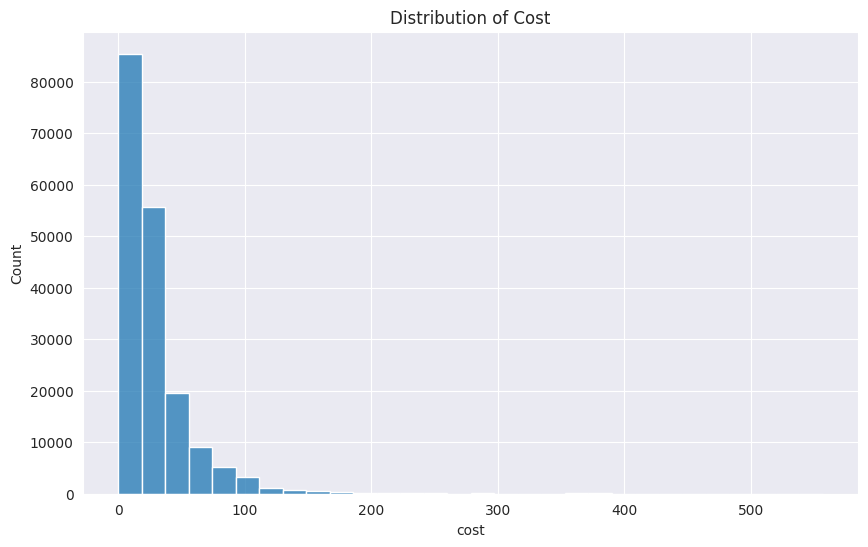

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(merged_orders_inventory['cost'], bins=30)
plt.title("Distribution of Cost")
plt.show()

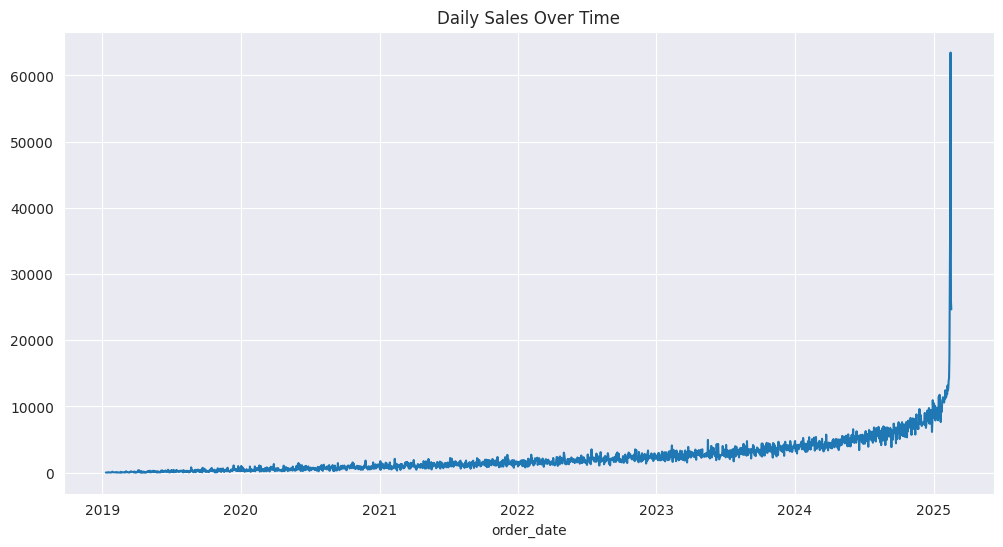

In [22]:
daily_sales = merged_orders_inventory.groupby(merged_orders_inventory['order_date'].dt.date)['cost'].sum()
plt.figure(figsize=(12,6))
daily_sales.plot()
plt.title("Daily Sales Over Time")
plt.show()


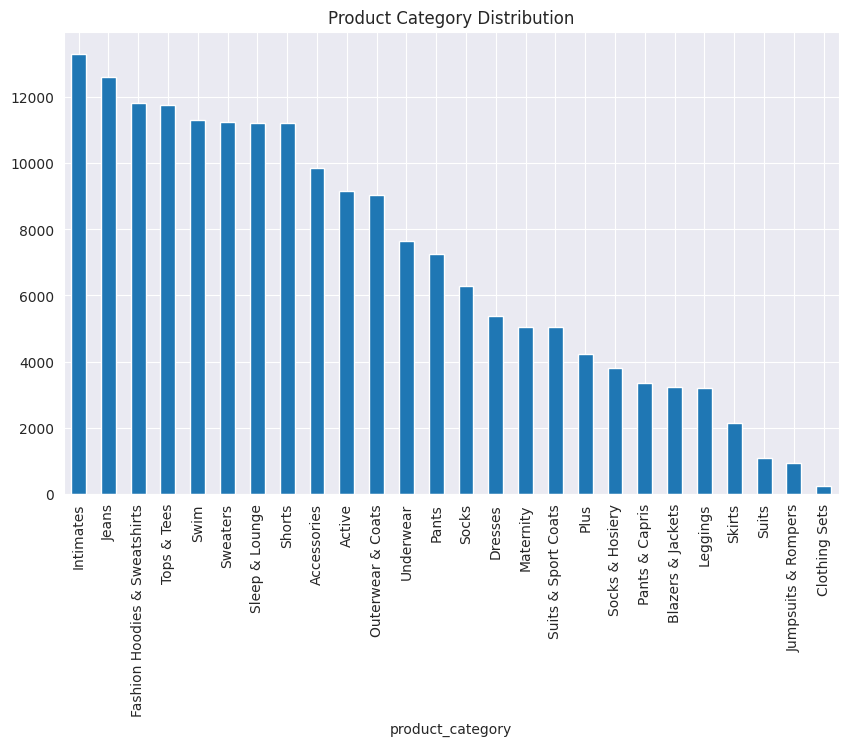

In [23]:
merged_orders_inventory['product_category'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title("Product Category Distribution")
plt.show()

$$
\text{Product Level Insight}
$$

In [250]:
insight_df = merged_orders_inventory.copy()

insight_df = insight_df.groupby('product_id').agg(
    product_name=('product_name', 'first'),
    total_orders=('order_id', 'nunique'),
    total_quantity=('num_of_item', 'sum'),
    total_revenue=('sale_price', 'sum'),
    avg_sale_price=('sale_price', 'mean')
).reset_index()

In [251]:
insight_df = insight_df.sort_values(by='total_revenue', ascending=False)
insight_df.head()

,product_id,product_name,total_orders,total_quantity,total_revenue,avg_sale_price
23483,23546,Alpha Industries Rip Stop Short,12,22,11988.0,999.0
23740,23803,Canada Goose Men's The Chateau Jacket,12,20,9780.0,815.0
8397,8429,The North Face Women's S-XL Oso Jacket,10,17,9030.0,903.0
22864,22927,AIR JORDAN DOMINATE SHORTS MENS 465071-100,10,17,9030.0,903.0
23585,23648,The North Face Apex Bionic Jacket - Men's,10,16,9030.0,903.0


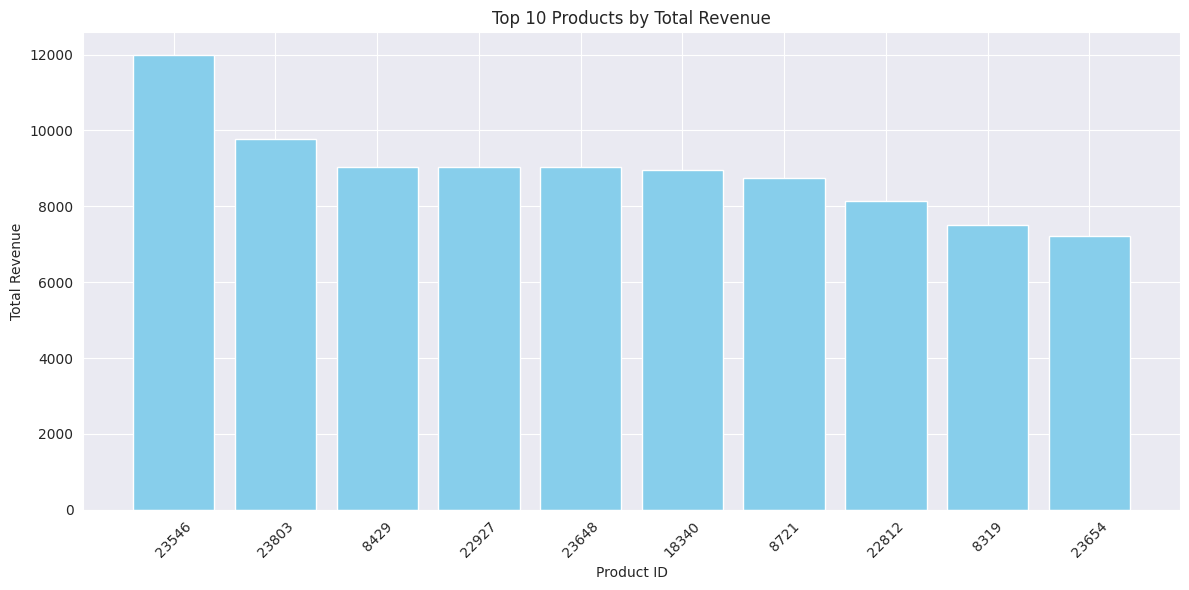

In [252]:
top_10 = insight_df.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10['product_id'].astype(str), top_10['total_revenue'], color='skyblue')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue')
plt.title('Top 10 Products by Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [256]:
insight_df[['product_id', 'product_name']].head(10)

,product_id,product_name
23483,23546,Alpha Industries Rip Stop Short
23740,23803,Canada Goose Men's The Chateau Jacket
8397,8429,The North Face Women's S-XL Oso Jacket
22864,22927,AIR JORDAN DOMINATE SHORTS MENS 465071-100
23585,23648,The North Face Apex Bionic Jacket - Men's
18282,18340,Canada Goose Men's The Chateau Jacket
8689,8721,Nobis Merideth Parka
22749,22812,Quiksilver Men's Rockefeller Walkshort
8287,8319,Canada Goose Women's Mystique
23591,23654,The North Face Apex Bionic Soft Shell Jacket - Men's


$$
\text{RFM Analysis}
$$
$$
\text{Recency(How many days since last purchase), Frequency(Total number of orders), Monetary(Total spend)}
$$

In [206]:
ref_date = merged_orders_inventory['order_date'].max() + pd.Timedelta(days=1)

rfm = merged_orders_inventory.groupby('user_id').agg({
    'order_date': lambda x: (ref_date - x.max()).days,
    'order_id': 'count',
    'cost': 'sum'
}).reset_index()

rfm.columns = ['user_id', 'recency', 'frequency', 'monetary']

In [207]:
rfm.head()

,user_id,recency,frequency,monetary
0,1,1025,2,29.199571
1,2,217,2,69.167241
2,4,450,1,51.370000
3,5,21,9,204.154881
4,7,41,1,17.942400


$$
\text{Clustering}
$$

In [208]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

In [209]:
rfm_scaled

array([[ 1.22535237, -0.16631272, -0.54317441],
       [-0.53660272, -0.16631272,  0.06456632],
       [-0.02851419, -0.78644661, -0.20605512],
       ...,
       [-0.95528512,  0.45382117,  0.35197614],
       [ 0.07397577, -0.16631272,  0.41581574],
       [ 2.05835589, -0.78644661, -0.71354135]])

In [210]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [211]:
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.4039315209472784


In [212]:
cluster_summary = rfm.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
})
print(cluster_summary)

             recency  frequency    monetary
Cluster                                    
0        1189.365312   1.544817   40.750995
1         274.589733   3.557252  101.459366
2         294.124452   5.903373  227.600538
3         259.634384    1.38538   32.259697


https://www.optimove.com/resources/learning-center/rfm-segmentation

$$
\text{Divide Customers into Tiers}
$$

In [216]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79996 entries, 0 to 79995
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   user_id    79996 non-null  Int64   
 1   recency    79996 non-null  int64   
 2   frequency  79996 non-null  Int64   
 3   monetary   79996 non-null  float64 
 4   Cluster    79996 non-null  int32   
 5   R_tier     79996 non-null  category
dtypes: Int64(2), category(1), float64(1), int32(1), int64(1)
memory usage: 3.0 MB


In [220]:
rfm['R_tier'] = pd.qcut(rfm['recency'], 4, duplicates='drop').cat.codes + 1
rfm['F_tier'] = 4 - pd.qcut(rfm['frequency'], 4, duplicates='drop').cat.codes
rfm['M_tier'] = 4 - pd.qcut(rfm['monetary'], 4, duplicates='drop').cat.codes
rfm['RFM_Segment'] = (
    rfm['R_tier'].astype(str) + '-' +
    rfm['F_tier'].astype(str) + '-' +
    rfm['M_tier'].astype(str)
)

print(rfm[['user_id', 'recency', 'frequency', 'monetary', 'R_tier', 'F_tier', 'M_tier', 'RFM_Segment']].head())


   user_id  recency  frequency    monetary  R_tier  F_tier  M_tier RFM_Segment
0        1     1025          2   29.199571       4       4       3       4-4-3
1        2      217          2   69.167241       2       4       2       2-4-2
2        4      450          1   51.370000       3       4       2       3-4-2
3        5       21          9  204.154881       1       2       1       1-2-1
4        7       41          1   17.942400       1       4       4       1-4-4


$$
\text{Best Customers 1-1-1}
$$
$$
\text{High-spending New Customers 1-4-1 1-4-2}
$$
$$
\text{Low-Spending Active Loyal Customers 1-1-3 1-1-4 2-1-3 2-1-4}
$$
$$
\text{Churned Best/Great Customers 4-1-1 4-1-2 4-2-1 4-2-2}
$$
$$
\text{Others (could make more assignments)}
$$

In [228]:
def assign_customer(rfm_segment):
    if rfm_segment == "1-1-1":
        return "Champions"
    elif rfm_segment == "1-4-1" or rfm_segment == "1-4-2":
        return "High-spending New Customers"
    elif rfm_segment in ['1-1-3', '1-1-3', '2-1-3', '2-1-4']:
        return "Low-spending Active Loyal Customers"
    elif rfm_segment in ['4-1-1', '4-1-2', '4-2-1', '4-2-2']:
        return "Churned Best/Great Customers"
    else:
        return "Others"


In [229]:
rfm["Segment_Name"] = rfm['RFM_Segment'].apply(assign_customer)

In [235]:
print(rfm)

       user_id  recency  frequency    monetary  Cluster  R_tier  F_tier  \
0            1     1025          2   29.199571        0       4       4   
1            2      217          2   69.167241        3       2       4   
2            4      450          1   51.370000        3       3       4   
3            5       21          9  204.154881        2       1       2   
4            7       41          1   17.942400        3       1       4   
...        ...      ...        ...         ...      ...     ...     ...   
79991    99994      602          4  145.086049        1       3       2   
79992    99995      409          2   87.549180        3       3       4   
79993    99996       25          3   88.068559        1       1       3   
79994    99999      497          2   92.266929        1       3       4   
79995   100000     1407          1   17.995501        0       4       4   

       M_tier RFM_Segment Segment_Name  
0           3       4-4-3       Others  
1           2    

$$
\text{Creating Table with SegmentName, userid, products bought by customer for future marketing models}
$$

In [236]:
orders_info = merged_orders_inventory[['order_id','user_id', 'status', 'product_name', 'product_category']].copy()
rfm_info = rfm[['user_id', 'Segment_Name']].copy()

merged_df = pd.merge(orders_info, rfm_info, on='user_id', how='left')
merged_df.set_index('user_id', inplace=True)

$$
\text{Split orders on status for better customer service}
$$

In [238]:
merged_df = merged_df[merged_df['Segment_Name'].str.lower() != 'others']
merged_df.head()

,order_id,status,product_name,product_category,Segment_Name
user_id,,,,,
29,30,Shipped,LRG The Travel Unravel TS Jeans in Dark Charcoal,Jeans,Churned Best/Great Customers
29,31,Returned,Storus Smart Black Matte Money Clip,Accessories,Churned Best/Great Customers
29,31,Returned,Savane Men's Deep Dye Microfiber Pleated Gaberdine Pant,Pants,Churned Best/Great Customers
29,31,Returned,Pendleton Men's Classic Fit Board Shirt,Tops & Tees,Churned Best/Great Customers
29,32,Shipped,Kenneth Cole Reaction Men's Fitted Tonal Solid Dress Shirt,Tops & Tees,Churned Best/Great Customers


$$
\text{Revenue and Income Predictions}
$$

In [31]:
time_series_rev = merged_orders_inventory.copy()

In [32]:
columns_to_drop = [
    'order_id', 'user_id', 'gender', 'num_of_item',
    'product_id', 'inventory_item_id', 'product_retail_price',
    'product_department', 'status'
]
time_series_rev.drop(columns=columns_to_drop, inplace=True)


In [33]:
time_series_rev.head()

,order_date,sale_price,cost,product_category,product_name
0,2022-04-30 09:37:00+00:00,14.970000,7.485000,Plus,Collections Etc - Button Front Argyle V-Neck Career Sweater
1,2022-04-30 09:37:00+00:00,39.990002,21.714571,Tops & Tees,Patty Women Cowl Neck Button Embellished Ruched Blouse Top
2,2024-07-16 14:52:00+00:00,25.000000,10.025000,Swim,Body Glove Juniors Smoothies Skirt Rider Swim Bottom
3,2024-07-16 14:52:00+00:00,98.080002,59.142241,Suits,Evan Picone English Rose Skirt Suit
4,2023-11-26 12:03:00+00:00,110.000000,51.370000,Sweaters,Christopher Fischer Women's 100% Cashmere Long-Sleeve Striped Dip-Dyed Cardigan


In [34]:
time_series_rev['order_date'] = pd.to_datetime(time_series_rev['order_date'], errors='coerce')

time_series_rev['order_month'] = time_series_rev['order_date'].dt.strftime('%Y-%m')

In [35]:
time_series_rev

,order_date,sale_price,cost,product_category,product_name,order_month
0,2022-04-30 09:37:00+00:00,14.970000,7.485000,Plus,Collections Etc - Button Front Argyle V-Neck Career Sweater,2022-04
1,2022-04-30 09:37:00+00:00,39.990002,21.714571,Tops & Tees,Patty Women Cowl Neck Button Embellished Ruched Blouse Top,2022-04
2,2024-07-16 14:52:00+00:00,25.000000,10.025000,Swim,Body Glove Juniors Smoothies Skirt Rider Swim Bottom,2024-07
3,2024-07-16 14:52:00+00:00,98.080002,59.142241,Suits,Evan Picone English Rose Skirt Suit,2024-07
4,2023-11-26 12:03:00+00:00,110.000000,51.370000,Sweaters,Christopher Fischer Women's 100% Cashmere Long-Sleeve Striped Dip-Dyed Cardigan,2023-11
...,...,...,...,...,...,...
181441,2024-10-07 11:16:00+00:00,69.989998,32.615339,Shorts,True Religion Brand Jeans Womens Corgo Shorts Black,2024-10
181442,2025-01-24 11:16:00+00:00,37.990002,16.259721,Dresses,Short Sleeve Cowl Neck Fitted Warm Winter Plaid Sweater Mini Dress Top S M L,2025-01
181443,2022-07-07 09:46:00+00:00,31.990000,20.697530,Socks,Diamond Supply Co HI OG 2 Stripe Socks 3pk - Men's,2022-07
181444,2023-10-10 09:46:00+00:00,146.059998,71.569399,Jeans,7 For All Mankind Men's Slimmy Slim Straight Leg Jean in Los Angeles Dark,2023-10


In [36]:
time_series_rev['revenue'] = time_series_rev['sale_price']
time_series_rev['income'] = time_series_rev['sale_price'] - time_series_rev['cost']

In [37]:
time_series = time_series_rev.groupby('order_month').agg({
    'sale_price': 'sum',
    'cost': 'sum',
    'revenue': 'sum',
    'income': 'sum'
}).reset_index()

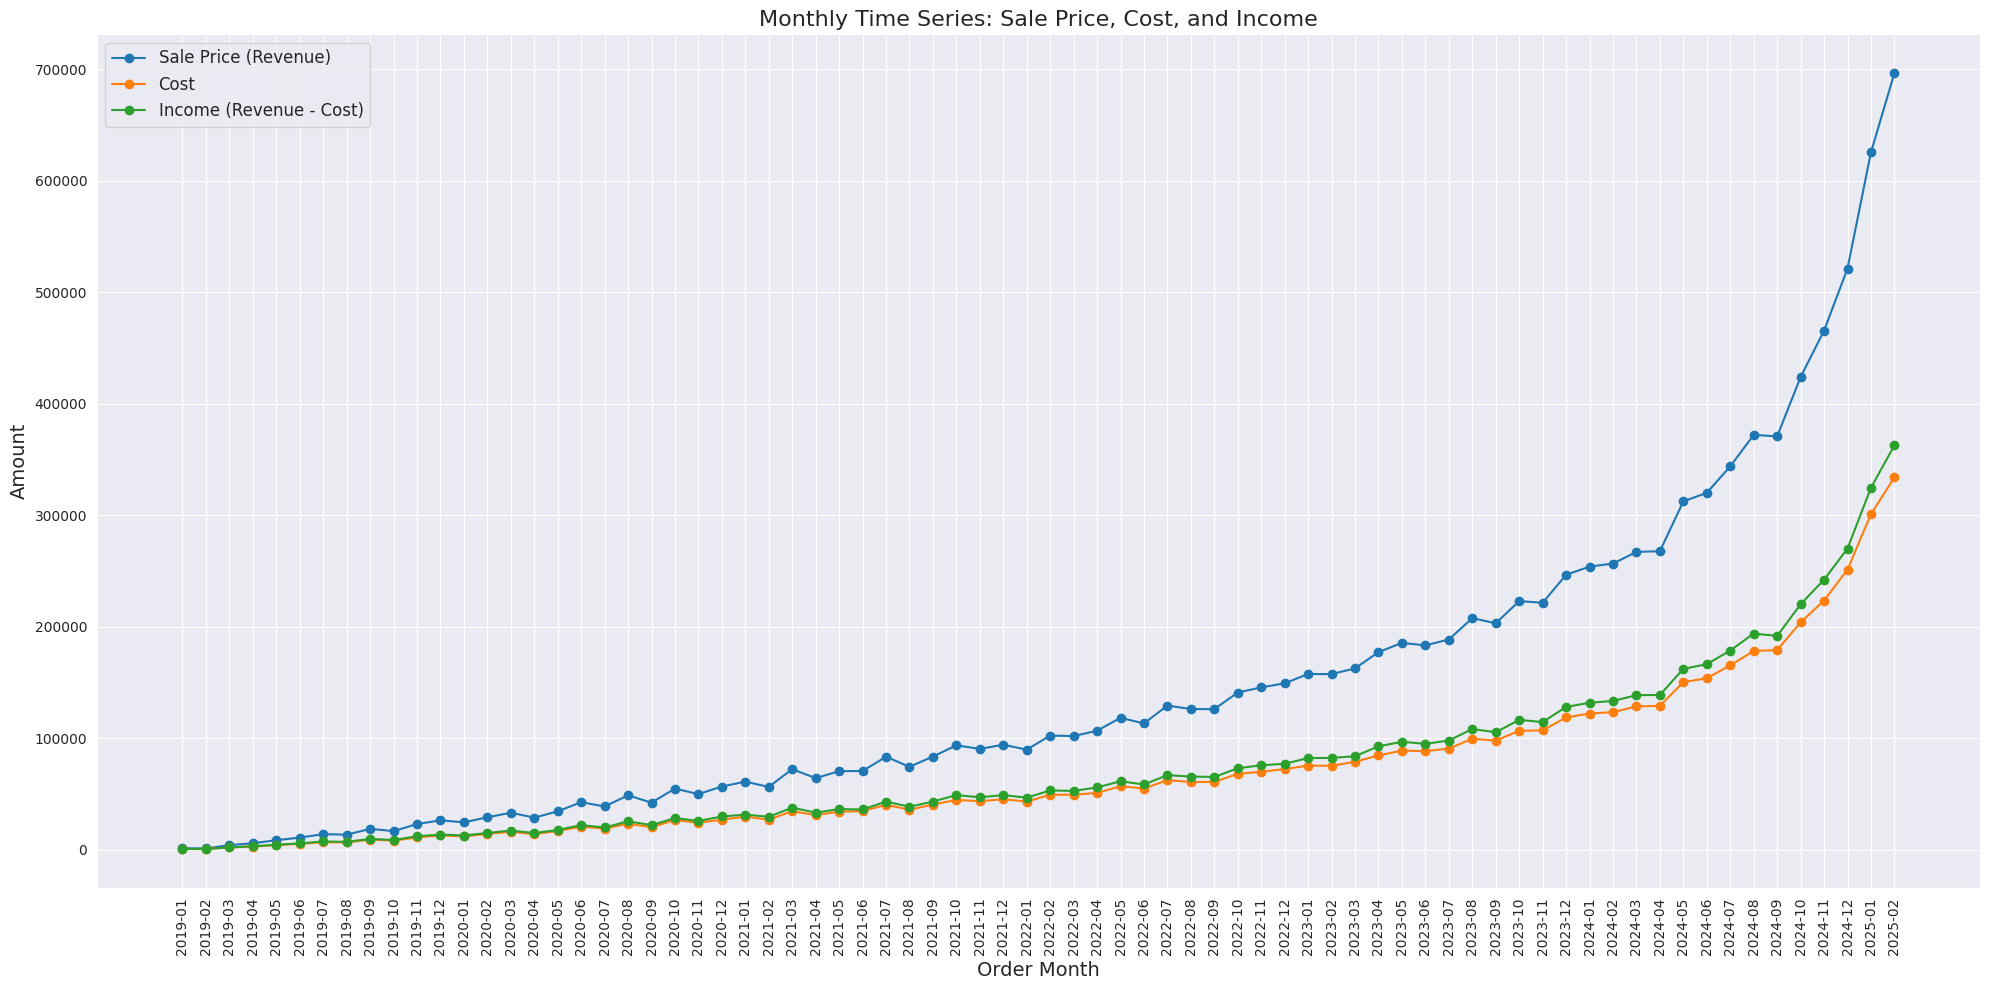

In [38]:
plt.figure(figsize=(20, 10))

plt.plot(time_series['order_month'], time_series['sale_price'], marker='o', label='Sale Price (Revenue)')
plt.plot(time_series['order_month'], time_series['cost'], marker='o', label='Cost')
plt.plot(time_series['order_month'], time_series['income'], marker='o', label='Income (Revenue - Cost)')

plt.title("Monthly Time Series: Sale Price, Cost, and Income", fontsize=16)
plt.xlabel("Order Month", fontsize=14)
plt.ylabel("Amount", fontsize=14)
plt.legend(fontsize=12)

plt.xticks(rotation=90)

plt.tight_layout()

plt.show()

In [39]:
time_series_rev.head()

,order_date,sale_price,cost,product_category,product_name,order_month,revenue,income
0,2022-04-30 09:37:00+00:00,14.970000,7.485000,Plus,Collections Etc - Button Front Argyle V-Neck Career Sweater,2022-04,14.970000,7.485000
1,2022-04-30 09:37:00+00:00,39.990002,21.714571,Tops & Tees,Patty Women Cowl Neck Button Embellished Ruched Blouse Top,2022-04,39.990002,18.275431
2,2024-07-16 14:52:00+00:00,25.000000,10.025000,Swim,Body Glove Juniors Smoothies Skirt Rider Swim Bottom,2024-07,25.000000,14.975000
3,2024-07-16 14:52:00+00:00,98.080002,59.142241,Suits,Evan Picone English Rose Skirt Suit,2024-07,98.080002,38.937761
4,2023-11-26 12:03:00+00:00,110.000000,51.370000,Sweaters,Christopher Fischer Women's 100% Cashmere Long-Sleeve Striped Dip-Dyed Cardigan,2023-11,110.000000,58.630000


In [40]:
future_rev_df = time_series_rev.drop(['product_category', 'product_name', 'sale_price', 'order_month', 'order_date'], axis=1).copy()
future_rev_df.index = merged_orders_inventory['order_date'].dt.strftime('%Y-%m-%d')

In [41]:
future_rev_df

,cost,revenue,income
order_date,,,
2022-04-30,7.485000,14.970000,7.485000
2022-04-30,21.714571,39.990002,18.275431
2024-07-16,10.025000,25.000000,14.975000
2024-07-16,59.142241,98.080002,38.937761
2023-11-26,51.370000,110.000000,58.630000
...,...,...,...
2024-10-07,32.615339,69.989998,37.374659
2025-01-24,16.259721,37.990002,21.730281
2022-07-07,20.697530,31.990000,11.292470


In [42]:
unique_order_dates = future_rev_df.groupby('order_date').sum().reset_index()
unique_order_dates.set_index('order_date', inplace=True)

In [58]:
unique_order_dates

,cost,revenue,income,income_dif
order_date,,,,
2019-01-10,15.450000,30.000000,14.550000,NaN
2019-01-13,23.026330,52.110000,29.083670,14.533670
2019-01-15,11.375000,25.000000,13.625000,-15.458670
2019-01-17,67.843019,147.989998,80.146979,66.521979
2019-01-19,29.306491,60.980001,31.673511,-48.473468
...,...,...,...,...
2025-02-13,26742.907379,55610.920083,28868.012704,10136.851959
2025-02-14,38536.290120,80186.470041,41650.179921,12782.167218
2025-02-15,63451.061417,132405.080118,68954.018701,27303.838780


$$
\text{Future income prediction model, per day, there's some missing days in df that can cause some miss predictions}
$$
$$
\text{Check if the df is good for ARIMA model p < 0.05}
$$

In [45]:
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller

adf = adfuller(unique_order_dates['income'])
print(f'ADF stats: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF stats: 2.1698366585783777
p-value: 0.9988567553596375


$$
y'_t = y_t - y_{t-1}
$$

In [51]:
unique_order_dates['income_dif'] = unique_order_dates['income'].diff()
diff_series = unique_order_dates['income_dif'].dropna()

In [48]:
diff_series.head()

order_date
2019-01-13    14.533670
2019-01-15   -15.458670
2019-01-17    66.521979
2019-01-19   -48.473468
2019-01-21   -18.657001
Name: income_dif, dtype: float64

In [50]:
adf_diff = adfuller(diff_series)
print(f'ADF stats: {adf_diff[0]}')
print(f'p-value: {adf_diff[1]}')

ADF stats: 5.803437025014467
p-value: 1.0


In [136]:
from prophet import Prophet

f_income = unique_order_dates.reset_index()[['order_date', 'income']].copy()

In [137]:
f_income.columns = ['ds', 'y']

In [138]:
f_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      2201 non-null   object 
 1   y       2201 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.5+ KB


In [146]:
model = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

model.fit(f_income)

13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:35 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
future_dates = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future_dates)

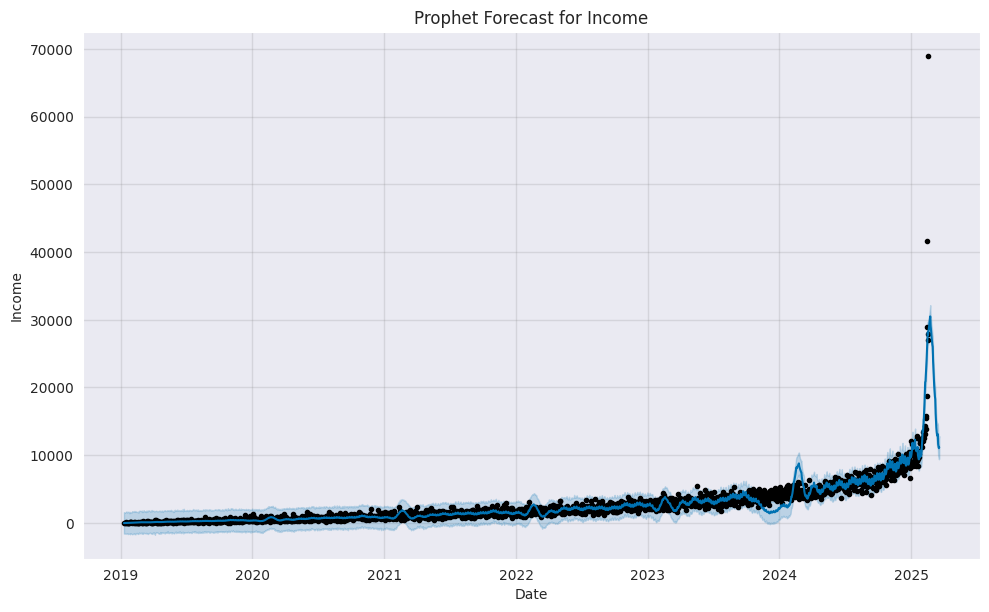

In [148]:
model.plot(forecast)
plt.title("Prophet Forecast for Income")
plt.xlabel("Date")
plt.ylabel("Income")
plt.show()

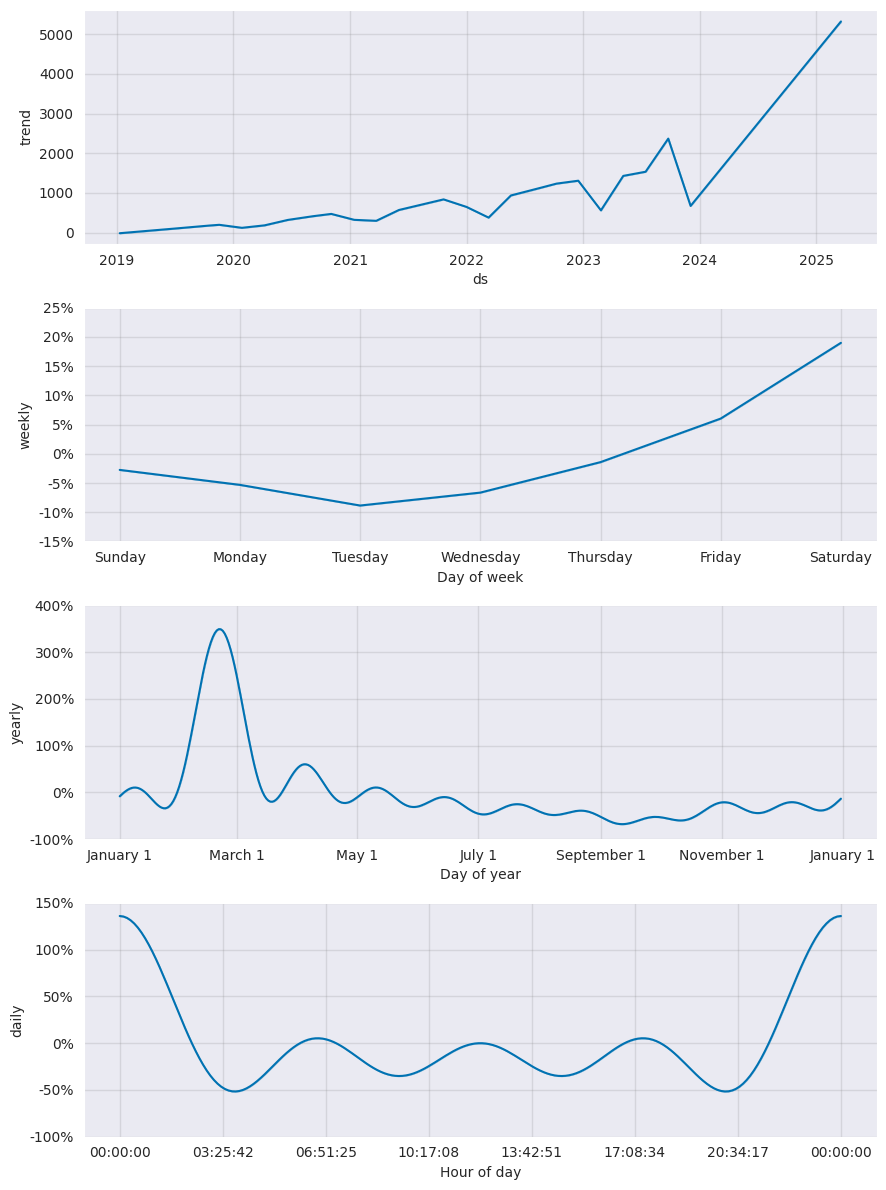

In [149]:
model.plot_components(forecast)
plt.show()

In [150]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(40))

             ds          yhat    yhat_lower    yhat_upper
2191 2025-02-08  20796.088776  19245.353011  22434.104020
2192 2025-02-09  20885.038804  19336.512621  22566.713603
2193 2025-02-10  21911.465792  20294.689876  23583.860136
2194 2025-02-11  22862.633467  21231.601358  24554.877240
2195 2025-02-12  24054.609264  22559.391160  25618.995797
2196 2025-02-13  25335.088270  23627.050101  27044.016009
2197 2025-02-14  26649.770055  25053.545221  28141.987424
2198 2025-02-15  28147.084362  26504.766823  29697.669832
2199 2025-02-16  27797.344447  26287.582757  29433.556867
2200 2025-02-17  28285.538097  26637.254790  29902.421797
2201 2025-02-18  28591.860012  26908.275080  30253.997308
2202 2025-02-19  29046.204251  27331.733766  30596.101242
2203 2025-02-20  29505.720432  27873.279571  31121.904595
2204 2025-02-21  29928.865158  28342.091851  31565.248344
2205 2025-02-22  30481.286408  28898.441405  32149.074482
2206 2025-02-23  29121.825752  27575.995426  30769.234643
2207 2025-02-2

In [151]:
forecast[['ds', 'yhat']].tail(40)

,ds,yhat
2191,2025-02-08,20796.088776
2192,2025-02-09,20885.038804
2193,2025-02-10,21911.465792
2194,2025-02-11,22862.633467
2195,2025-02-12,24054.609264
2196,2025-02-13,25335.088270
2197,2025-02-14,26649.770055
2198,2025-02-15,28147.084362
2199,2025-02-16,27797.344447
2200,2025-02-17,28285.538097


In [152]:
unique_order_dates['income'].tail(10)

order_date
2025-02-08    13120.955638
2025-02-09    13894.599354
2025-02-10    15750.211534
2025-02-11    15450.976243
2025-02-12    18731.160744
2025-02-13    28868.012704
2025-02-14    41650.179921
2025-02-15    68954.018701
2025-02-16    27859.858524
2025-02-17    27034.854870
Name: income, dtype: float64

In [184]:
f_month_inc = unique_order_dates.reset_index().drop(['cost', 'revenue', 'income_dif'], axis=1).copy()
f_month_inc

,order_date,income
0,2019-01-10,14.550000
1,2019-01-13,29.083670
2,2019-01-15,13.625000
3,2019-01-17,80.146979
4,2019-01-19,31.673511
...,...,...
2196,2025-02-13,28868.012704
2197,2025-02-14,41650.179921
2198,2025-02-15,68954.018701
2199,2025-02-16,27859.858524


In [186]:
f_month_inc.columns = ['ds','y']
f_month_inc['ds'] = pd.to_datetime(f_month_inc['ds'], errors='coerce')
f_month_inc['ds'] = f_month_inc['ds'].dt.to_period('M').dt.to_timestamp()
f_month_inc = f_month_inc.groupby('ds')['y'].sum().reset_index()
# f_month_inc['ds'] = f_month_inc['ds'].dt.strftime('%Y-%m')

f_month_inc

,ds,y
0,2019-01-01,585.040690
1,2019-02-01,534.652898
2,2019-03-01,2042.365285
3,2019-04-01,3010.335063
4,2019-05-01,4372.607501
...,...,...
69,2024-10-01,220117.200969
70,2024-11-01,242176.171203
71,2024-12-01,270111.468634
72,2025-01-01,324615.727164


In [187]:
month_model = Prophet(
    changepoint_prior_scale=0.3,
    seasonality_mode='multiplicative'
)

month_model.fit(f_month_inc)

14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing


In [188]:
month_df = month_model.make_future_dataframe(periods=10, freq='MS')
month_forecast = month_model.predict(month_df)

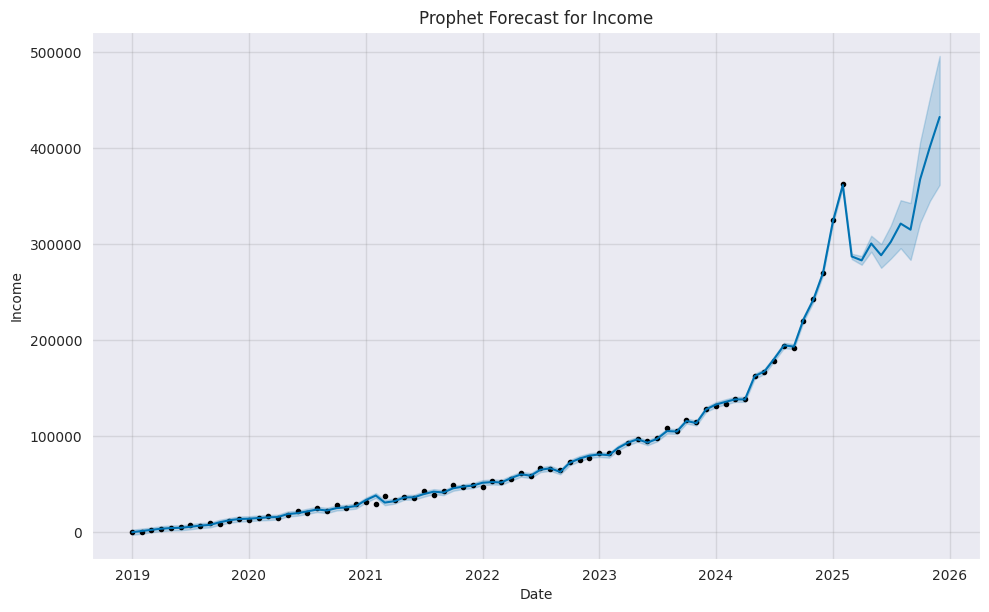

In [189]:
month_model.plot(month_forecast)
plt.title("Prophet Forecast for Income")
plt.xlabel("Date")
plt.ylabel("Income")
plt.show()

In [197]:
month_forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']].tail(20)

,ds,yhat_lower,yhat_upper,yhat
64,2024-05-01,159498.988741,164887.652512,162331.631212
65,2024-06-01,164612.700571,170043.810174,167328.862651
66,2024-07-01,177697.969569,182838.221502,180222.641397
67,2024-08-01,191559.984356,197075.243387,194470.601696
68,2024-09-01,190478.368429,195760.545924,193132.217435
69,2024-10-01,218926.755842,224028.897425,221432.624407
70,2024-11-01,239369.560562,244730.876901,242015.067938
71,2024-12-01,267177.938197,272473.582951,269675.579435
72,2025-01-01,320541.925318,326024.449127,323264.706522
73,2025-02-01,358552.497508,363840.918745,361236.508630


In [195]:
f_month_inc[['ds','y']].tail(20)

,ds,y
54,2023-07-01,97866.225014
55,2023-08-01,108198.201012
56,2023-09-01,105305.021200
57,2023-10-01,116374.418564
58,2023-11-01,114450.054212
59,2023-12-01,127975.932628
60,2024-01-01,131776.072860
61,2024-02-01,133371.694540
62,2024-03-01,138539.440058
63,2024-04-01,138773.281166


$$
\text{Month predictions shows better results}
$$